In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from pathlib import Path
from sklearn.metrics import cohen_kappa_score, f1_score

# 1. Evaluation on controlled dataset

In [1]:
#annot_fever_dplaceq = "../../data/ablations/discrepancies/results/v1/FEVER-DPLACE-Q_v2_discp.csv"

annot_fever_dplaceq = "../../data/ablations/discrepancies/results/v2/FEVER-DPLACE-Q_v3_discp.csv"

In [3]:
df = pd.read_csv(annot_fever_dplaceq)
#df = df[df.label!="NOT_ENOUGH_INFO"]

models = ["qwen:32b", "llama3.3:70b", "gpt-4o-2024-08-06"]
f1_results = []

for model in models:
    per_class_f1 = []
    
    for label in df["label"].unique():
        # Create binary labels (1 if this label, 0 otherwise)
        true_binary = (df["label"] == label).astype(int)
        pred_binary = (df[f"discp_{model}"] == label).astype(int)

        # Compute F1-score for this specific label
        f1 = f1_score(true_binary, pred_binary, average="binary")
        per_class_f1.append(f1)

        # Store per-class F1-score
        f1_results.append({"Label": label, "Model": model, "F1-score": f1})

    # Compute Weighted-F1 for the model
    weighted_f1 = f1_score(df["label"], df[f"discp_{model}"], average="weighted")
    f1_results.append({"Label": "Weighted-F1", "Model": model, "F1-score": weighted_f1})

# Convert results to DataFrame
f1_df = pd.DataFrame(f1_results)

# Sort models correctly
model_order = models
f1_df["Model"] = pd.Categorical(f1_df["Model"], categories=model_order, ordered=True)

# Pivot for LaTeX output
latex_table = f1_df.pivot(index="Label", columns="Model", values="F1-score")
latex_table = latex_table[model_order]  # Ensure correct column order

# Convert to LaTeX table
latex_output = latex_table.to_latex(float_format="%.3f", caption="F1-score per Label and Weighted-F1", label="tab:f1_scores")
print(latex_output)

latex_table

\begin{table}
\caption{F1-score per Label and Weighted-F1}
\label{tab:f1_scores}
\begin{tabular}{lrrr}
\toprule
Model & qwen:32b & llama3.3:70b & gpt-4o-2024-08-06 \\
Label &  &  &  \\
\midrule
CONTRADICTION & 0.935 & 0.883 & 0.962 \\
CULTURAL_DISCREPANCY & 0.889 & 0.809 & 0.869 \\
NOT_ENOUGH_INFO & 0.825 & 0.889 & 0.889 \\
NO_DISCREPANCY & 0.980 & 0.961 & 0.942 \\
Weighted-F1 & 0.914 & 0.885 & 0.918 \\
\bottomrule
\end{tabular}
\end{table}



Model,qwen:32b,llama3.3:70b,gpt-4o-2024-08-06
Label,,,
CONTRADICTION,0.934579,0.882883,0.961538
CULTURAL_DISCREPANCY,0.888889,0.808511,0.868687
NOT_ENOUGH_INFO,0.825397,0.888889,0.888889
NO_DISCREPANCY,0.980000,0.960784,0.942308
Weighted-F1,0.913850,0.884973,0.917501


/tmp/ipykernel_233544/2462201246.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


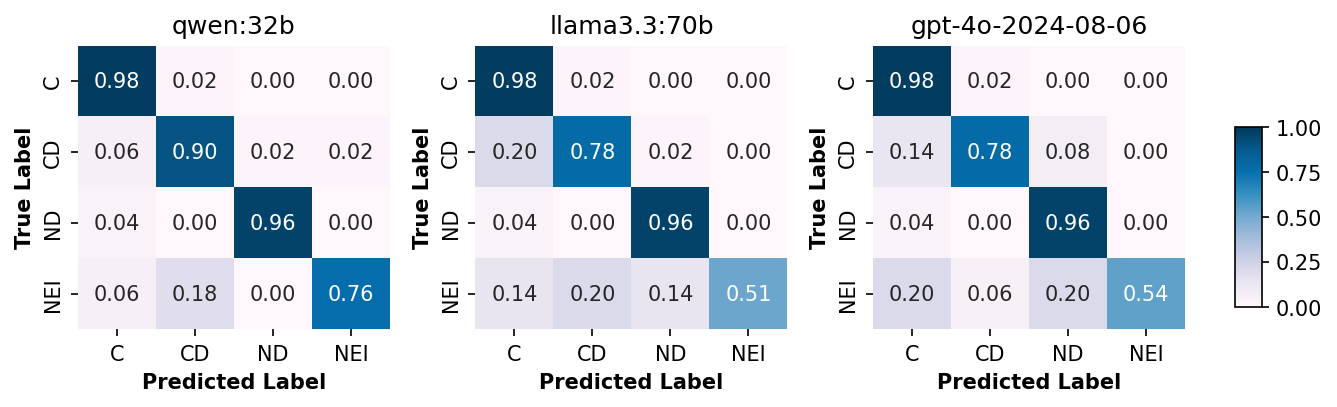

In [4]:
true_col = "label"
pred_cols = OrderedDict([
    ("qwen:32b", "discp_qwen:32b"),
    ("llama3.3:70b", "discp_llama3.3:70b"),
    ("gpt-4o-2024-08-06", "discp_gpt-4o-2024-08-06"),
])

# fixed order and pretty tick labels
order = ["CONTRADICTION", "CULTURAL_DISCREPANCY", "NO_DISCREPANCY", "NOT_ENOUGH_INFO"]
abbr = {"CONTRADICTION": "C", "CULTURAL_DISCREPANCY": "CD", "NO_DISCREPANCY": "ND", "NOT_ENOUGH_INFO": "NEI"}
true_labels = [abbr[x] for x in order]
pred_labels = true_labels  # same order for columns

def row_norm_confusion(y_true, y_pred, labels):
    ct = pd.crosstab(
        pd.Categorical(y_true, categories=labels),
        pd.Categorical(y_pred, categories=labels),
        dropna=False
    ).astype(float)
    row_sums = ct.sum(axis=1).replace(0, np.nan)
    m = (ct.T / row_sums).T.fillna(0.0)
    # return as DataFrame with pretty tick labels to pass to seaborn
    m.index = [abbr[i] for i in m.index]
    m.columns = [abbr[j] for j in m.columns]
    return m

# compute matrices for each model
models = OrderedDict()
for title, col in pred_cols.items():
    models[title] = row_norm_confusion(df[true_col], df[col], order)

# --- Plotting (your styling) ---
fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
vmin, vmax = 0.0, 1.0
cmap = "PuBu"  # Updated color palette

for ax, (title, matrix) in zip(axes, models.items()):
    sns.heatmap(
        matrix, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax,
        xticklabels=pred_labels, yticklabels=true_labels, ax=ax, cbar=False
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Predicted Label", fontsize=10, fontweight='bold')
    ax.set_ylabel("True Label", fontsize=10, fontweight='bold')

# shared colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(bottom=0.25)

# optional: save
plt.savefig("/export/usuarios_ml4ds/lbartolome/Repos/umd/mind/figures/thesis/confusion_fever_d_place_q_fixed.png", dpi=300, bbox_inches="tight")

plt.show()


# 2. Evaluation on controlled + ROSIE samples by humans

In [65]:
df = pd.read_excel("../../data/ablations/discrepancies/eval_tasks/discrepancies_v5.xlsx")
df

,Unnamed: 0,id_discr,source,question,answer_t,answer_s,discrepancy,model,reason,label
0,0,0,FEVER-DPLACE-Q,Is the initial marital residence typically est...,"Yes, it is often avunculocal, residing with or...","No, it is ambilocal, with residence optionally...",CULTURAL_DISCREPANCY,synthetic,synthetic,NaN
1,1,1,11,Is the risk of serious complications from amni...,"YES, the risk of serious complications from am...","YES, the risk of serious complications from am...",NO_DISCREPANCY,gpt-4o,Both answers provide consistent information re...,NaN
2,2,2,11,Has placental vasoconstriction been observed i...,"YES, placental vasoconstriction has been obser...","YES, placental vasoconstriction has been obser...",NO_DISCREPANCY,qwen:32b,Both answers are identical and directly confir...,NaN
3,3,3,FEVER-DPLACE-Q,Did Quentin Tarantino make a movie?,"Yes, Quentin Tarantino made a movie.","Yes, Quentin Tarantino made several movies, in...",NO_DISCREPANCY,synthetic,synthetic,NaN
4,4,4,11,Does erythroblastosis fetalis refer to a condi...,"YES, erythroblastosis fetalis refers to a cond...","NO, erythroblastosis fetalis specifically refe...",CONTRADICTION,llama3.3:70b,The answers provide directly opposing informat...,NaN
...,...,...,...,...,...,...,...,...,...,...
360,360,360,11,Should you contact your provider if you experi...,"YES, you should contact your provider if you e...","YES, you should contact your provider if you e...",NO_DISCREPANCY,llama3.3:70b,Both ANSWER_1 and ANSWER_2 agree on the action...,NaN
361,361,361,15,Does neonatal respiratory distress syndrome (R...,"YES, neonatal respiratory distress syndrome (R...","YES, neonatal respiratory distress syndrome (R...",NO_DISCREPANCY,qwen:32b,Both answers agree that neonatal respiratory d...,NaN
362,362,362,FEVER-DPLACE-Q,Has Emily Blunt yet to appear in a film adapte...,"Yes, Emily Blunt has yet to appear in a film a...","No, Emily Blunt appeared in ""Salmon Fishing in...",CONTRADICTION,synthetic,synthetic,NaN
363,363,363,FEVER-DPLACE-Q,Is animal husbandry typically performed by mal...,No data is available on this specialization.,"Yes, it is primarily performed by males, with ...",NOT_ENOUGH_INFO,synthetic,synthetic,NaN


In [66]:
pivot = (
    df.groupby(["source", "model", "discrepancy"])
      .size()
      .unstack(fill_value=0)   # discrepancy values become columns
      .reset_index()
)

pivot


discrepancy,source,model,CONTRADICTION,CULTURAL_DISCREPANCY,NOT_ENOUGH_INFO,NO_DISCREPANCY
0,11,gpt-4o,0,0,10,10
1,11,llama3.3:70b,10,3,10,10
2,11,qwen:32b,8,4,10,10
3,15,gpt-4o,0,0,10,10
4,15,llama3.3:70b,13,6,10,10
5,15,qwen:32b,10,6,10,10
6,FEVER-DPLACE-Q,synthetic,50,50,35,50


In [64]:
df_aux = df[df.model!="synthetic"]

subset = df_aux.loc[df_aux.discrepancy == 'CULTURAL_DISCREPANCY',
                    ['question', 'answer_s', 'answer_t']]

for _, row in subset.iterrows():
    print(f"QUESTION: {row['question']}")
    print(f"ANSWER_s: {row['answer_s']}")
    print(f"ANSWER_t: {row['answer_t']}")
    print("\n-----")

QUESTION: Should you contact a lactation consultant if your baby has problems swallowing or feeding?
ANSWER_s: YES, if your baby has problems swallowing or feeding, you should contact a lactation consultant for help. This is mentioned in the passage as a recommended step if you're concerned about your baby's feeding.
ANSWER_t: YES, if your baby has problems swallowing or feeding, you should contact a lactation consultant or your baby's healthcare provider for assistance. They can provide guidance and support to ensure proper feeding and address any issues that may arise.

-----
QUESTION: If a woman who is lactating chooses to consume alcohol moderately, what is the recommended maximum number of standard drinks per day?
ANSWER_s: YES, moderate consumption of alcoholic beverages by a woman who is lactating is not known to be harmful to the infant if she limits intake to up to 1 standard drink in a day and waits at least 2 hours after a single drink before nursing or expressing breast mil

In [31]:
path_task = Path("../../data/ablations/discrepancies/results/v1")
path_original = path_task / "discrepancies_v4.xlsx"
path_ann1 = path_task / "discrepancies_v4_ann1.xlsx"
path_ann2 = path_task / "discrepancies_v4_ann2.xlsx"

In [32]:
df = pd.read_excel(path_original)

In [33]:
# this can vary depending on the annotator (they sometimes don't follow instructions)
df_ann=pd.read_excel(path_ann1)
df_ann["label"] = df_ann["Label"]
df_ann["label"] = df_ann["label"].replace("Contradiction", "CONTRADICTION")
df_ann["label"] = df_ann["label"].replace("Cultural_Discrepancy", "CULTURAL_DISCREPANCY")
df_ann["label"] = df_ann["label"].replace("No_Discrepancy", "NO_DISCREPANCY")
df_ann["label"] = df_ann["label"].replace("No_discrepancy", "NO_DISCREPANCY")
df_ann["label"] = df_ann["label"].replace("No_dicrepancies", "NO_DISCREPANCY")
df_ann["label"] = df_ann["label"].replace("Not_Enough_Info", "NOT_ENOUGH_INFO")
print(df_ann.label.unique())
print(f"number of CONTRADICTION: {len(df_ann[df_ann.label == 'CONTRADICTION'])/len(df_ann)}")
print(f"number of NO_DISCREPANCY: {len(df_ann[df_ann.label == 'NO_DISCREPANCY'])/len(df_ann)}")
print(f"number of CULTURAL_DISCREPANCY: {len(df_ann[df_ann.label == 'CULTURAL_DISCREPANCY'])/len(df_ann)}")

['CONTRADICTION' 'CULTURAL_DISCREPANCY' 'NO_DISCREPANCY' 'NOT_ENOUGH_INFO']
number of CONTRADICTION: 0.2490272373540856
number of NO_DISCREPANCY: 0.42412451361867703
number of CULTURAL_DISCREPANCY: 0.1828793774319066


In [34]:
df_ann2 = pd.read_excel(path_ann2)
df_ann2["label2"] = df_ann2["label"]

In [35]:
df_ann = df_ann.merge(df_ann2[["id_discr", "label2"]], on="id_discr", how="left")

df_ann = df_ann.merge(df[["id_discr", "model", "discrepancy", "reason"]], on="id_discr", how="left")
df_ann["model"] = df_ann["model"].fillna("synthetic")
df_ann["model"] = df_ann["model"].apply(lambda x: x.replace('gpt-4o-2024-08-06', 'gpt-4o'))
df_ann["agree"] = df_ann["label"] == df_ann["discrepancy"]
df_ann["agree2"] = df_ann["label2"] == df_ann["discrepancy"]
keep_cols = [col for col in df_ann if not col.startswith("Unnamed")]
df_ann = df_ann[keep_cols]

df_summary = df_ann.groupby(["model", "discrepancy"]).agg(
    agree_count=("agree", "sum"),    
    agree2_count=("agree2", "sum"),  
    total=("agree", "count")
).reset_index()

df_summary["agree_ratio"] = df_summary["agree_count"] / df_summary["total"]
df_summary["agree2_ratio"] = df_summary["agree2_count"] / df_summary["total"]

df_summary

,model,discrepancy,agree_count,agree2_count,total,agree_ratio,agree2_ratio
0,gpt-4o,NO_DISCREPANCY,18,18,18,1.000000,1.000000
1,llama3.3:70b,CONTRADICTION,7,6,8,0.875000,0.750000
2,llama3.3:70b,NO_DISCREPANCY,17,19,19,0.894737,1.000000
3,qwen:32b,CONTRADICTION,2,4,5,0.400000,0.800000
4,qwen:32b,CULTURAL_DISCREPANCY,0,2,5,0.000000,0.400000
5,qwen:32b,NO_DISCREPANCY,17,15,18,0.944444,0.833333
6,synthetic,CONTRADICTION,49,45,50,0.980000,0.900000
7,synthetic,CULTURAL_DISCREPANCY,44,48,50,0.880000,0.960000
8,synthetic,NOT_ENOUGH_INFO,32,33,34,0.941176,0.970588
9,synthetic,NO_DISCREPANCY,49,47,50,0.980000,0.940000


In [24]:
df_ann.label.unique()

array(['CONTRADICTION', 'CULTURAL_DISCREPANCY', 'NO_DISCREPANCY',
       'NOT_ENOUGH_INFO'], dtype=object)

In [49]:
df_ann = df_ann[
    (df_ann.Label!="NOT_ENOUGH_INFO") &
    (df_ann.label!="NOT_ENOUGH_INFO") &
    (df_ann.label2!="NOT_ENOUGH_INFO")
]

## 2.1. Agreement

In [50]:
inter_annotator_kappa = cohen_kappa_score(df_ann["label"], df_ann["label2"])

print(f"Inter-annotator Cohen's Kappa: {inter_annotator_kappa:.3f}")

Inter-annotator Cohen's Kappa: 0.833


In [51]:
agreement_results = []

for (model, category), group in df_ann.groupby(["model", "discrepancy"]):
    f1_label = f1_score(group["label"], group["discrepancy"], average="weighted")
    f1_label2 = f1_score(group["label2"], group["discrepancy"], average="weighted")

    agreement_results.append({
        "model": model,
        "category": category,
        "f1_label": f1_label,
        "f1_label2": f1_label2
    })

agreement_by_category_df = pd.DataFrame(agreement_results)

agreement_by_category_df

,model,category,f1_label,f1_label2
0,gpt-4o,NO_DISCREPANCY,1.000000,1.000000
1,llama3.3:70b,CONTRADICTION,1.000000,0.791209
2,llama3.3:70b,NO_DISCREPANCY,0.917460,1.000000
3,qwen:32b,CONTRADICTION,0.333333,0.642857
4,qwen:32b,CULTURAL_DISCREPANCY,0.000000,0.228571
5,qwen:32b,NO_DISCREPANCY,0.912656,0.827206
6,synthetic,CONTRADICTION,0.970101,0.852632
7,synthetic,CULTURAL_DISCREPANCY,0.876812,0.968860
8,synthetic,NOT_ENOUGH_INFO,0.000000,0.000000
9,synthetic,NO_DISCREPANCY,0.970101,0.910928


In [52]:
agreement_results = []

for (model, category), group in df_ann.groupby(["model", "discrepancy"]):
    f1_label = f1_score(group["label"], group["discrepancy"], average="weighted")
    f1_label2 = f1_score(group["label2"], group["discrepancy"], average="weighted")

    agreement_results.append({
        "model": model,
        "category": category,
        "f1_label": f1_label,
        "f1_label2": f1_label2
    })

agreement_by_category_df = pd.DataFrame(agreement_results)

agreement_by_category_df

,model,category,f1_label,f1_label2
0,gpt-4o,NO_DISCREPANCY,1.000000,1.000000
1,llama3.3:70b,CONTRADICTION,1.000000,0.791209
2,llama3.3:70b,NO_DISCREPANCY,0.917460,1.000000
3,qwen:32b,CONTRADICTION,0.333333,0.642857
4,qwen:32b,CULTURAL_DISCREPANCY,0.000000,0.228571
5,qwen:32b,NO_DISCREPANCY,0.912656,0.827206
6,synthetic,CONTRADICTION,0.970101,0.852632
7,synthetic,CULTURAL_DISCREPANCY,0.876812,0.968860
8,synthetic,NOT_ENOUGH_INFO,0.000000,0.000000
9,synthetic,NO_DISCREPANCY,0.970101,0.910928


## 2.2. Discrepancy category figure

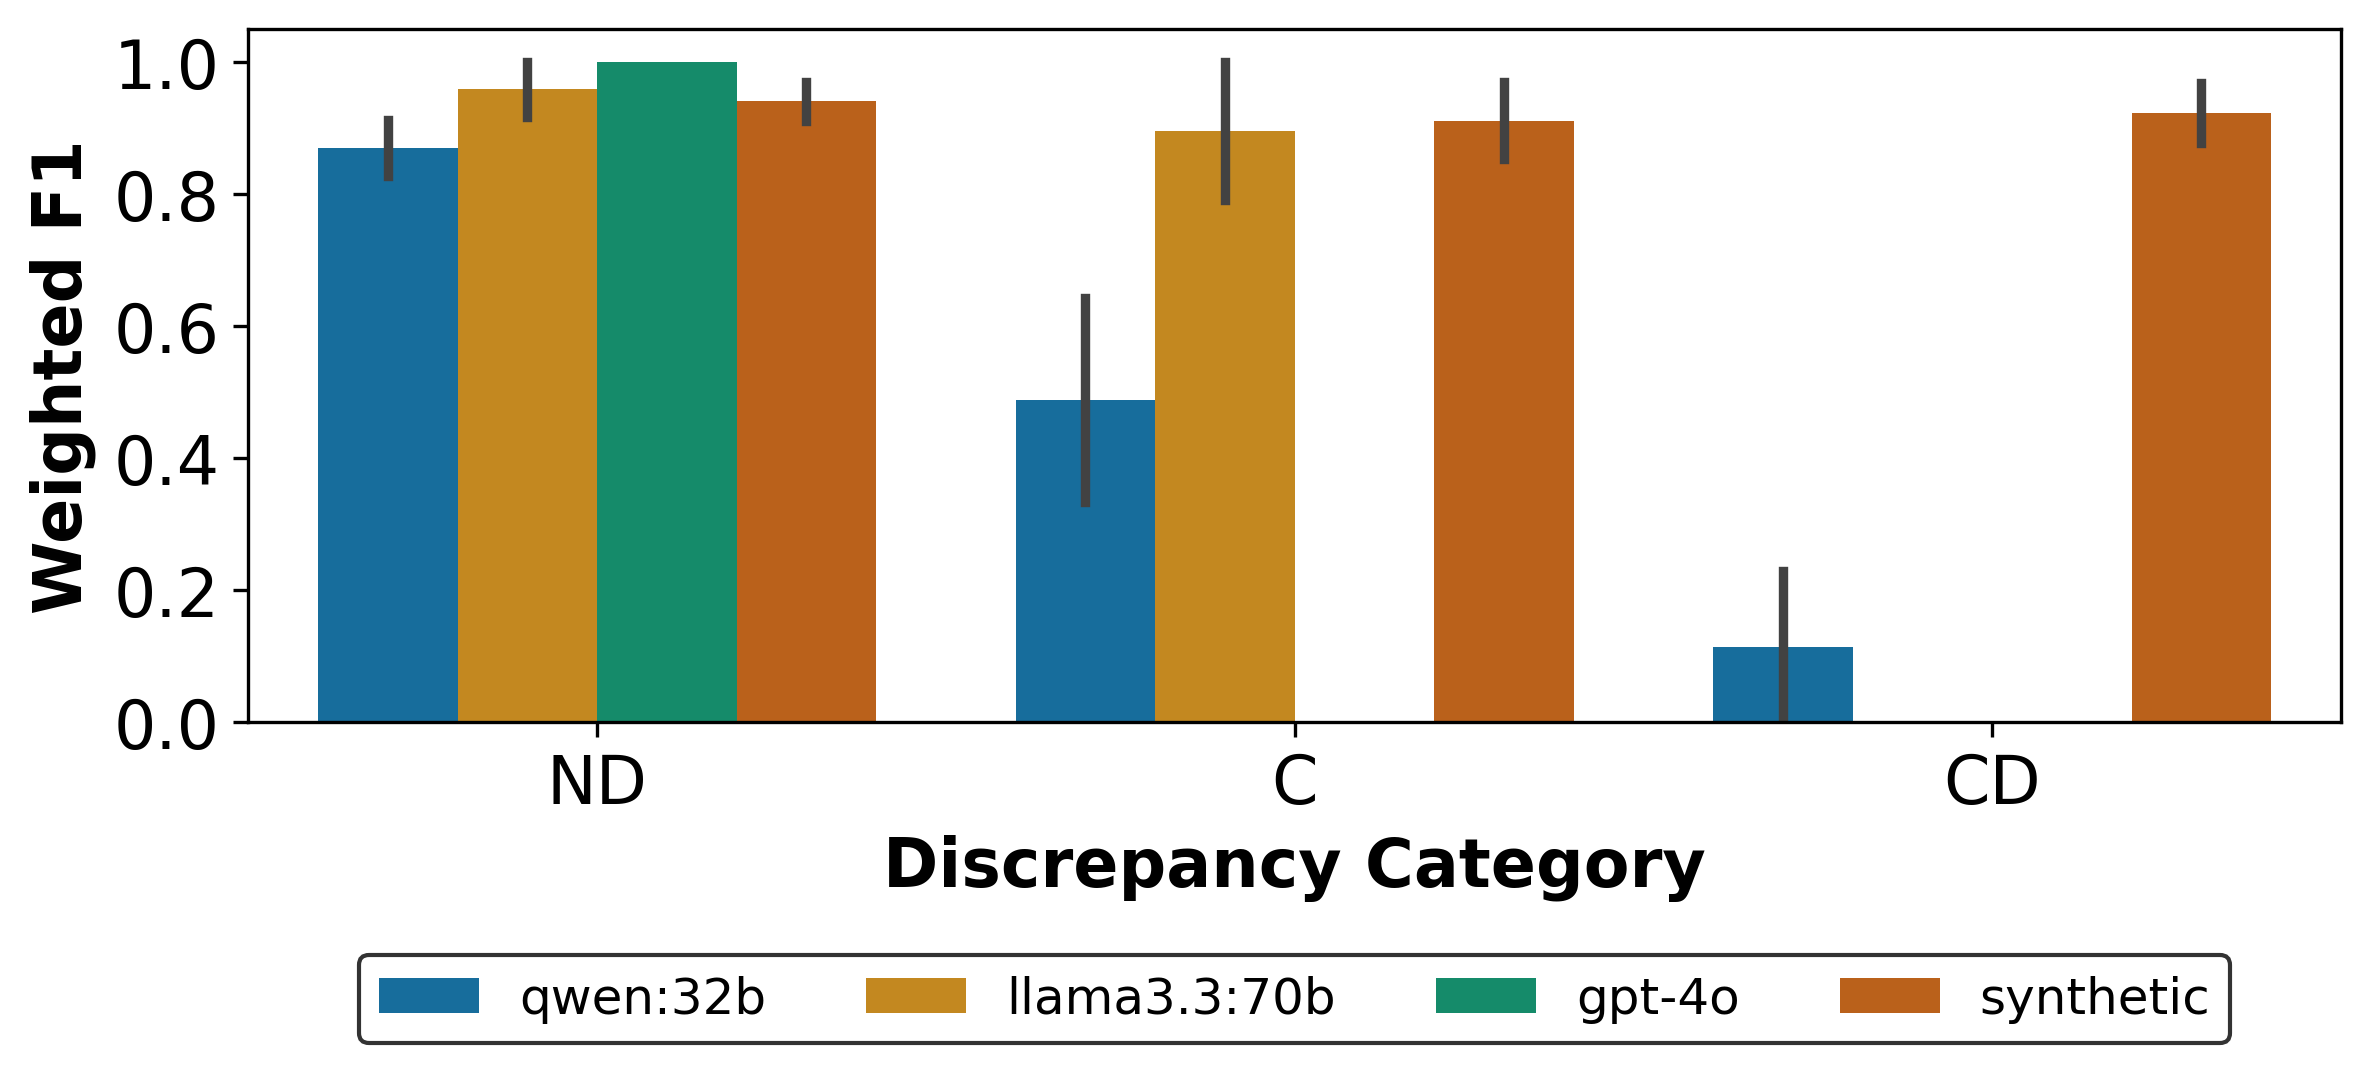

In [56]:
category_labels = {
    "NO_DISCREPANCY": "ND",
    "CONTRADICTION": "C",
    "CULTURAL_DISCREPANCY": "CD",
    #"NOT_ENOUGH_INFO": "NEI"
}

model_order = ["qwen:32b", "llama3.3:70b", "gpt-4o", "FEVER-DPLACE-Q"]

agreement_by_category_df = agreement_by_category_df[
    agreement_by_category_df["category"] != "NOT_ENOUGH_INFO"
]
agreement_by_category_df["category"] = agreement_by_category_df["category"].replace(category_labels)

all_models = agreement_by_category_df["model"].unique()
full_model_order = [m for m in model_order if m in all_models] + [m for m in all_models if m not in model_order]

agreement_by_category_df["model"] = pd.Categorical(agreement_by_category_df["model"], categories=full_model_order, ordered=True)#

plt.figure(figsize=(9, 3), dpi=300)

ax = sns.barplot(
    data=agreement_by_category_df.melt(id_vars=["model", "category"], value_vars=["f1_label", "f1_label2"]),
    x="category", y="value", hue="model", palette="colorblind", hue_order=full_model_order
)

plt.xlabel("Discrepancy Category", fontsize=16, fontweight="bold")
plt.ylabel("Weighted F1", fontsize=16, fontweight="bold")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=True, fontsize=12)
legend.get_frame().set_edgecolor("black")

plt.savefig("../../figures/thesis/mind_discrepancy_evaluation.png", dpi=300, bbox_inches="tight")

plt.show()

# 3. Analysis of discrepancies detected in the final run

In [15]:
paths_final = [
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc15_complete/answers/questions_topic_15_qwen:32b_23400_results_model30tpc_thr__dynamic.parquet",
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc11_complete/answers/questions_topic_11_qwen:32b_14300_results_model30tpc_thr__dynamic.parquet",
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc24_complete/answers/questions_topic_24_qwen:32b_18900_results_model30tpc_thr__dynamic.parquet",
]

all_ = []
for path in paths_final:
    df = pd.read_parquet(path)
    tpc= path.split("_tpc")[-1].split("_")[0]
    df["topic"]=tpc

    # cleaning 
    df.loc[df['answer_t'].str.contains("cannot answer the question given the context", na=False), 'discrepancy'] = "NOT_ENOUGH_INFO"
    df.loc[df["answer_t"] == "I cannot answer given the context.", ["discrepancy"]] = "NOT_ENOUGH_INFO"
    df.loc[df["discrepancy"] == "TYPE: NO_", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "NO DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "NO_ONGOING_DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: CULTURAL_ DISCREPANCY", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "CULTURAL_DISCREPANCY (if we consider that slight variations in recommendations might exist due to cultural influences or different parenting practices, though it's a weak case for this category)", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "CULTURAL_DISCREPANCY (if you consider the slight difference in number of exposures as stemming from different studies or expert opinions)", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "TYPE: CULTURAL_", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ DISCREPANCY", "NO_DISCREPANCY")
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ENOUGH_INFO", "NOT_ENOUGH_INFO")
    df["discrepancy"] = df["discrepancy"].str.replace("CULTURAL_ DISCREPANCY", "CULTURAL_DISCREPANCY")
    
    all_.append(df)

df = pd.concat(all_)
valid_values = {"CONTRADICTION", "NO_DISCREPANCY", "CULTURAL_DISCREPANCY", "NOT_ENOUGH_INFO"}
df = df[df["discrepancy"].isin(valid_values)]
print(df.discrepancy.unique())
len(df)

['NOT_ENOUGH_INFO' 'NO_DISCREPANCY' 'CULTURAL_DISCREPANCY' 'CONTRADICTION']


258044

In [16]:
print(df.columns)

# remove duplicates by question and passage_t (i.e., relevant passage is the same for the same question)
df = df.drop_duplicates(subset=["question", "passage_t"])
len(df)

Index(['question_id', 'doc_id', 'question', 'passage_s', 'answer_s',
       'passage_t', 'answer_t', 'discrepancy', 'reason', 'topic'],
      dtype='object')


129022

In [17]:
discrepancy_counts = df.groupby("topic")["discrepancy"].value_counts().unstack().fillna(0)
discrepancy_counts

discrepancy,CONTRADICTION,CULTURAL_DISCREPANCY,NOT_ENOUGH_INFO,NO_DISCREPANCY
topic,,,,
11,75,66,41426,2997
15,72,127,42094,2342
24,40,206,37070,2507
